In [16]:
import json
import pandas as pd
import requests
import datetime
from binance import Client
import matplotlib.pyplot as plt
import numpy as np
import os
from binance.client import Client
import datetime, time
from datetime import datetime
from numba import jit

# Бэктест_начало


In [17]:
# Требуется собрать данные в датафрейм df 
# Задаем даты начала и конца бектеста
start_date = '10/05/2022'
end_date = '15/09/2022'
# interval = '5 min' # '15 min', '30 min'

def GetHistoricalData(symbol, interval, fromDate, toDate):
    klines = client.get_historical_klines(symbol, interval, fromDate, toDate)
    df = pd.DataFrame(klines, columns=['dateTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore'])
    df.dateTime = pd.to_datetime(df.dateTime, unit='ms')
    df['date'] = df.dateTime.dt.strftime("%d/%m/%Y")
    df['time'] = df.dateTime.dt.strftime("%H:%M:%S")
    df = df.drop(['dateTime', 'closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol','takerBuyQuoteVol', 'ignore'], axis=1)
    column_names = ["date", "time", "open", "high", "low", "volume"]
    df = df.reindex(columns=column_names)
    return df
    
api_key = ""
api_secret = ""
client = Client(api_key, api_secret)


fromDate = str(datetime.strptime(start_date, '%d/%m/%Y'))
toDate = str(datetime.strptime(end_date, '%d/%m/%Y'))
symbol = "ETHUSDT"
interval = Client.KLINE_INTERVAL_5MINUTE
df = GetHistoricalData(symbol, interval, fromDate, toDate)

In [18]:
start_price =  1635.15
end_price =  1633.49

In [19]:
df[48*12-1:]

,date,time,open,high,low,volume
575,11/05/2022,23:55:00,2075.90000000,2087.85000000,2071.78000000,2157.28460000
576,12/05/2022,00:00:00,2084.99000000,2106.10000000,2082.11000000,6483.24450000
577,12/05/2022,00:05:00,2088.56000000,2103.00000000,2077.35000000,4081.49130000
578,12/05/2022,00:10:00,2095.69000000,2120.00000000,2081.45000000,9108.15130000
579,12/05/2022,00:15:00,2116.01000000,2118.99000000,2092.25000000,7692.73500000
...,...,...,...,...,...,...
36860,14/09/2022,23:40:00,1630.38000000,1633.99000000,1627.78000000,2570.28170000
36861,14/09/2022,23:45:00,1633.80000000,1636.34000000,1629.54000000,1652.27410000
36862,14/09/2022,23:50:00,1632.08000000,1639.06000000,1632.08000000,1336.76900000
36863,14/09/2022,23:55:00,1637.66000000,1638.93000000,1633.00000000,1474.00200000


## Определим 3 функции прибыли:  
Пока они вне класса, нужно внести их. 


In [133]:
def unforward_earnings(start_price, end_price, high_board, low_board):
    """Функция должна получить всю необходимую информацию и возвратить итоговую прибыль-убыток в пуле.
    Тут не учитываются заработанные комиссии. Только изменение стоимости токенов и их соотношение"""
    # Если после 24(или другого) периода цена оказалась выше изначальной
    p_ETH = (high_board-start_price)/(high_board-low_board)# доля ETH
    p_USDT = (1-p_ETH)# доля USDT
    if end_price >= start_price:
        if end_price >= high_board:
            res = ((high_board-start_price)/2+start_price)/start_price*p_ETH+p_USDT
        else:
            p = (end_price-start_price)/(high_board-start_price) # доля проданного ETH
            a1 = ((end_price-start_price)/2+start_price)/start_price*p*p_ETH
            a2 = p_USDT
            a3 = p_ETH*(1-p)*(end_price)/start_price #непроданный ETH
            res =  a1+a2+a3
    elif end_price < start_price:
        if end_price <= low_board:
            res = (p_USDT/(low_board+(start_price - low_board)/2)+p_ETH/start_price)*end_price
        else:
            p = (start_price-end_price)/(start_price-low_board) # доля обменянных долларов
            a1 = p_USDT*p/(end_price+(start_price - end_price)/2)*end_price# сумма от обменянных долларов
            a2 = p_USDT*(1-p) # остатки долларов
            a3 = p_ETH*end_price/start_price# изначальный подешевевший эфир
            res =  a1+a2+a3
    return (res-1)*100 # возвращаем результат в процентах!

def simple_hedge(start_price, end_price, ratio):
    '''Данная функция принимает начальную и конечную стоимость. А так же параметры хеджирования - долю хеджа
    Возвращает процентный заработок/убыток из за хеджа в % '''
    res = -(end_price-start_price)/start_price
    return res*100*ratio

def persentage_earnings(const=1):
    '''Функция принимает необходимые параметры и рассчитывает доходность в % от всех изначальных инвестиций
    Для начала используем константу - 1%'''
#     res = const
    res = 0.9 # тут ручками задать 
    return res

def calc_ratio(start_price, high_board, low_board):
    return (high_board-start_price)/(high_board-low_board)
    


In [21]:
################### Инициализация параметров обучения ######################
n_info = 24 # часов для обучения (не совсем обучение, скорее зависимая часть)
n_forcast = 24 # на какой период предсказываем
intervals_in_hour = 12 # какими интервалами оперируем здесь 12 - 5 минутки

### Далее класс, его просто инициализировать

In [22]:
# Класс который принимаем в себя всю необходимую информацию и подготавливает данные, рассчитывает интервалы и тп
class Interval_calculator:
    def __init__(self, df, n_info, n_forcast, intervals_in_hour):
        self.df = df
        self.n_info = n_info
        self.n_forcast = n_forcast
        self.intervals_in_hour = intervals_in_hour
        self.make_new_col()
        self.preob()
        self.calculate_intervals()
        self.make_data_for_back()
        self.get_periodic()
        self.make_dates()
    
    def make_dates(self):
        n_info, n_forcast, intervals_in_hour = self.n_info, self.n_forcast, self.intervals_in_hour
        df_for_dates = self.df.iloc[n_info*intervals_in_hour:len(df)-n_forcast*intervals_in_hour]
        dates = df_for_dates['date'].values
        final_dates = dates[::intervals_in_hour*n_forcast]
        self.dates = final_dates
        
    def make_new_col(self):
        '''Потребуются относительные изменения'''
        print('Добавляю относительные изменения')
        df = self.df
        mass = np.zeros(len(df))
        mass[0] = 1 # первую точку доопределяем 1
        values = df['open'].values.astype(float)
        for i in range(1, len(df)):
            mass[i] = values[i]/values[i-1]
            df['change'] = mass
        self.df = df
        return    
        
        
    def preob(self):
        '''Функция просто создает кучу разбивок для бутстрэпа и предсказания
        df - датасет
        n_info - сколько часов брать для "обучения"
        n_forcast - на сколько часов давать прогноз
        intervals_in_hour - количество выбранных интерваллов в часе (если минутные данные то 60)
        '''
        print('Создаю разбивку - данные для рассчета интервала и теста')
        df, n_info, n_forcast, intervals_in_hour = self.df, self.n_info, self.n_forcast, self.intervals_in_hour
        self.dict_res = {}
        for i in range(n_info*intervals_in_hour, len(df)-n_forcast*intervals_in_hour):
            fold_info = df[i-n_info*intervals_in_hour : i] # Срез датасета
            fold_res = df[i : i+n_forcast*intervals_in_hour] # Срез датасета
            self.dict_res[i] = [fold_info, fold_res] # В словаре лежат два датасета под каждым ключом
        return 
    
    @jit
    def bootstrap(self, mass, n_forcast, intervals_in_hour):
        '''Функция бутстрэпит изменения за прошедшие часы (это длина массива) n_forcast*intervals_in_hour раз, 
        процедура повторяется 10000 раз, в резульатате мы перемножеаем значения и выдаем прогноз в каждой точке таким образом (10000 симуляций)'''
        mass_res = np.zeros((10000, 2)) # 2 - нижняя и верхняя границы для каждой симуляции
        mass = np.array(mass) # переводим в numpy
        n = len(mass) # длина выборки для обучения
        size_forecast = n_forcast*intervals_in_hour
        # случайно берем числа до n, размера n_forcast*intervals_in_hour
        indexes = np.random.randint(n, size=size_forecast*10000)
        change = mass[[indexes]]
        change = change.reshape((10000, size_forecast))
        # теперь рассомтрим куммулятивное перемножение- предсказанное поведение
        cum_change = np.cumprod(change, axis=1)
        # минимальное и максимальные значения внутри временного интервалла
        min_ = np.min(cum_change, axis=1)
        max_ = np.max(cum_change, axis=1)
        sorted_res_min = np.sort(min_)
        sorted_res_max = np.sort(max_)
        high, low = sorted_res_max[9500], sorted_res_min[500]
        return np.array([high, low])
    
    def get_real(self, df):
      '''Функция нужна для валидации - возвращает верхние и нижние границы'''
      high = (df['high'].values.astype(float))
      low = (df['low'].values.astype(float))
      return np.hstack([high, low])
    
    def calculate_intervals(self):
        print('Рассчитываю интерваллы')
        dict_res, n_forcast, intervals_in_hour = self.dict_res, self.n_forcast, self.intervals_in_hour
        calculated_intervals = np.zeros((len(dict_res), 2))
        real_intervals = np.zeros((len(dict_res), n_forcast*intervals_in_hour*2)) # запоминаем  всю динамику  умножение на 2 тк записываем для верха и для низа
        k = 0
        for key in dict_res:
            real_intervals[k, :] = self.get_real(dict_res[key][1])

            # требуется для абсолютных значений запомнить цену открытия
            last_value = dict_res[key][0]['open'].values.astype(float)[-1]

            calculated = self.bootstrap(dict_res[key][0]['change'].values, n_forcast, intervals_in_hour)

            calculated_intervals[k, 0:2] = calculated*last_value
            k += 1
            j = int(len(dict_res)/200)
            if k % j == 0:
                print('progress = {} %'.format(round(k/len(dict_res)*100, 3)))
        self.intervals = calculated_intervals, real_intervals
        return

    def make_data_for_back(self):
        print('Преобразую данные для бэктеста')
        intervals, n_forcast, intervals_in_hour = self.intervals, self.n_forcast, self.intervals_in_hour
        # mass high, low, start, end
        k_end = n_forcast*intervals_in_hour-1
        mass = np.zeros((len(intervals[0]), 4))
        for i in range(len(intervals[0])):
            ###### тут сейчас берутся start, end, как high(в первую и последнюю 5 минутку)
            mass[i, :] = *intervals[0][i] , intervals[1][i][0], intervals[1][i][k_end]
    #         intervals[0][i] - high, low
    #         intervals[1][i][0] - start
    #         intervals[1][i][k] - end
        self.data_for_back = mass
        return
  
    
    def get_periodic(self):
        data_for_back, n_forcast, intervals_in_hour = self.data_for_back, self.n_forcast, self.intervals_in_hour
        '''Просто обрезка, выбор каждого n часового результата'''
        self.periodic_data_for_back = data_for_back[::n_forcast*intervals_in_hour, :]
        return 
    
    def back_test(self):
        '''Функция проводит анализ стратегии, возвращает список прибыли/убытков в каждый период'''
        mass_for_back, n_forcast = self.periodic_data_for_back, self.n_forcast
        earnings = np.zeros(len(mass_for_back))
#         print(ratio_for_hedge, hadge_type)
        for i in range(len(mass_for_back)):
            high_board, low_board, start_price, end_price = mass_for_back[i, :]

            e1 = unforward_earnings(start_price, end_price, high_board, low_board)
            # тут есть допущение - хедж для нас не требует блокировку активов - фьючерсы в общем ,причем бесплатные
            ratio_for_hedge = calc_ratio(start_price, high_board, low_board)
            e2 = simple_hedge(start_price, end_price, ratio_for_hedge)
            e3 = persentage_earnings()*n_forcast/24
            print('{} день'.format(i))
            print('start_price = ',start_price)
            print('end_price = ', end_price) 
            print('high_board = ', high_board)
            print('low_board = ', low_board)
            print('Непрямые потери/прибыли ',e1)
            print('Доход от хеджа ', e2)
            print('Процентный заработок ',e3)
            earnings[i] = e1+e2+e3
        return earnings
    
    def back_test_alt(self, start_amount, gas_price, verbose):
        '''Функция проводит анализ стратегии, возвращает список прибыли/убытков в каждый период'''
        mass_for_back, n_forcast = self.periodic_data_for_back, self.n_forcast
        earnings = np.zeros(len(mass_for_back))
        current_amount = start_amount
        for i in range(len(mass_for_back)):
            high_board, low_board, start_price, end_price = mass_for_back[i, :]
            # Рассчитываем долю эфира в средствах, которые вкладываем в пул
            ratio_hedge = calc_ratio(start_price, high_board, low_board)
            # Итого all_money = eth_pool+usd_pool+usd_hedge, eth_pool=usd_hedge
            # ratio_hedge = eth_pool/(eth_pool+usd_pool)
            # требуется расщепить current_amount на эти части:
            # То есть решить эти два уравнения:
#                 current_amount = usd_pool+2*eth_pool
#                 ratio_hedge = eth_pool/(eth_pool+usd_pool)
###### решаем... #####
# usd_pool = (current_amount - 2*eth_pool)
# ##### подставляем
# ratio_hedge = eth_pool/(eth_pool+(current_amount - 2*eth_pool))
# #####
# ratio_hedge = eth_pool/(current_amount - eth_pool)
# #####
# ratio_hedge*(current_amount - eth_pool)  = eth_pool
# ####
# ratio_hedge*current_amount  = eth_pool+ratio_hedge*eth_pool
# #####
# eth_pool = ratio_hedge*current_amount/(1+ratio_hedge) 
# -> usd_pool = current_amount - 2*eth_pool

            eth_pool = ratio_hedge*current_amount/(1+ratio_hedge)
            usd_pool = current_amount - 2*eth_pool
            usd_hedge = eth_pool

            # Получим непрямые прибыли/убытки от пула в процентах
            e1 = unforward_earnings(start_price, end_price, high_board, low_board)
            e1 = e1/100*(eth_pool+usd_pool) # переведем в деньги: прибыль

            # получим прибыль/убыток от хеджа
            e2 = simple_hedge(start_price, end_price, ratio_hedge)
            # небольшой костыль, чтобы вернуться просто к процентам от хеджа
            e2 = e2/(100*ratio_hedge)
            e2 = usd_hedge*e2  # переведем в доллары

            # получим прибыль от стейкинга
            e3 = persentage_earnings()*n_forcast/24
            e3 = e3/100 # уход от %
            e3 = (eth_pool+usd_pool)*e3# переведем в деньги
            # суммируем прибыли и изначальную сумму
            earn = e1 + e2 + e3 + current_amount - gas_price*2
            
            if verbose == True:
                print('{} день'.format(i))
                print('start_price = ',start_price)
                print('end_price = ', end_price) 
                print('high_board = ', high_board)
                print('low_board = ', low_board)
                print('Выделяем {} на usd_pool'.format(usd_pool))
                print('Выделяем {} на usd_hedge'.format(usd_hedge))
                print('Выделяем {} на eth_pool'.format(eth_pool))
                print('Непрямые потери/прибыли ', e1)
                print('Доход от хеджа ', e2)
                print('Процентный заработок ',e3)
                print()
            earnings[i] = earn
            # переопределяем старт на след день
            current_amount = earn
        return earnings
    
    def plot_results(self):
        fig = plt.figure(figsize = (10, 10))
        mass_for_back = self.periodic_data_for_back
        x = self.dates
        earnings = self.back_test()
        y = np.cumsum(earnings)
        plt.plot(x, y, label='Хеджируем эфир')
        plt.xlabel('Дата бектеста', fontsize=15)
        plt.ylabel('Доходность в %', fontsize=15)
        plt.xticks(fontsize = (20/len(x)+3), rotation=45)
        plt.title('Анализ итоговой доходности', fontsize = 15)
        plt.legend(prop={'size': 10})
        
    def plot_results_alt(self, start_amount, gas_price, verbose):
        '''Альтернативный рассчет, более строгий
        Здесь каждый раз капитал разбивается на несколько частей
        Часть уходит в хедж, часть в пул. Затем все суммируется и новая сумма идет в след день'''
        fig = plt.figure(figsize = (10, 10))
        mass_for_back = self.periodic_data_for_back
        x = self.dates
        
        earnings_alt = self.back_test_alt(start_amount, gas_price, verbose) 
        y = earnings_alt
        
        
        plt.plot(x, y, label='Хеджируем эфир')
        plt.xlabel('Дата бектеста', fontsize=15)
        plt.ylabel('Всего средств', fontsize=15)
        plt.xticks(fontsize = (20/len(x)+3), rotation=45)
        plt.title('Анализ итоговой доходности старт с {} $'.format(start_amount), fontsize = 15)
        plt.legend(prop={'size': 10})
        
    def plot_price(self):
        # Просто отрисовка того, как изменялся курс, чтобы интерпретировать прибыли и убытки в стратегии
        mass_for_back = self.periodic_data_for_back
        fig = plt.figure(figsize = (10, 10))
        plt.plot(self.dates, mass_for_back[:, 3])
        plt.xticks(fontsize = (20/len(self.dates)+3), rotation=45)
        plt.title('Курс ETH/USDT')
        
    def change_price_distr(self):
        mass_for_back = self.periodic_data_for_back
        change = np.zeros(len(mass_for_back))
        starts = mass_for_back[:, 2]
        ends = mass_for_back[:, 3]
        for i in range(len(change)):
            end = ends[i]
            start = starts[i]
            res = (end - start)/start*100 # итог в процентах +10% или -0.5%
            change[i] = res
        fig = plt.figure(figsize = (10, 10))
        plt.xlabel('Изменение стоимости в %', fontsize=15)
        plt.hist(change, bins=15)
        plt.show()


### Следующая строчка посчитает все интерваллы, минут 30 будет считать для 3х месяцев

In [23]:
back_test_obj = Interval_calculator(df, n_info, n_forcast, intervals_in_hour)

Добавляю относительные изменения
Создаю разбивку - данные для рассчета интервала и теста
Рассчитываю интерваллы


<ipython-input-22-c7194f50d88a>:52: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "bootstrap" failed type inference due to: non-precise type pyobject
During: typing of argument at <ipython-input-22-c7194f50d88a> (56)

File "<ipython-input-22-c7194f50d88a>", line 56:
    def bootstrap(self, mass, n_forcast, intervals_in_hour):
        <source elided>
        процедура повторяется 10000 раз, в резульатате мы перемножеаем значения и выдаем прогноз в каждой точке таким образом (10000 симуляций)'''
        mass_res = np.zeros((10000, 2)) # 2 - нижняя и верхняя границы для каждой симуляции
        ^

  @jit
/Users/vladislav705/opt/anaconda3/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "bootstrap" was compiled in object mode without forceobj=True.

File "<ipython-input-22-c7194f50d88a>", line 53:
    @jit
    def bootstrap(self, mass, n_forcast, intervals_in_hour):
    ^

  warnings.warn(errors.N

progress = 0.499 %
progress = 0.998 %
progress = 1.496 %
progress = 1.995 %
progress = 2.494 %
progress = 2.993 %
progress = 3.491 %
progress = 3.99 %
progress = 4.489 %
progress = 4.988 %
progress = 5.487 %
progress = 5.985 %
progress = 6.484 %
progress = 6.983 %
progress = 7.482 %
progress = 7.98 %
progress = 8.479 %
progress = 8.978 %
progress = 9.477 %
progress = 9.975 %
progress = 10.474 %
progress = 10.973 %
progress = 11.472 %
progress = 11.971 %
progress = 12.469 %
progress = 12.968 %
progress = 13.467 %
progress = 13.966 %
progress = 14.464 %
progress = 14.963 %
progress = 15.462 %
progress = 15.961 %
progress = 16.46 %
progress = 16.958 %
progress = 17.457 %
progress = 17.956 %
progress = 18.455 %
progress = 18.953 %
progress = 19.452 %
progress = 19.951 %
progress = 20.45 %
progress = 20.948 %
progress = 21.447 %
progress = 21.946 %
progress = 22.445 %
progress = 22.944 %
progress = 23.442 %
progress = 23.941 %
progress = 24.44 %
progress = 24.939 %
progress = 25.437 %
progr

### Следующая строка считает доходность в данной стратегии (возможно часы внизу не корректно указаны, по идее тут все 3 месяца)

0 день
start_price =  2350.0
end_price =  2087.85
high_board =  2829.2718244972443
low_board =  2125.02981762312
Непрямые потери/прибыли  -9.728517861531627
Доход от хеджа  7.591751286025321
Процентный заработок  0.8000000000000002
1 день
start_price =  2106.1
end_price =  1969.21
high_board =  2396.456921885169
low_board =  1472.6117011781062
Непрямые потери/прибыли  -2.540517577933832
Доход от хеджа  2.042799310830854
Процентный заработок  0.8000000000000002
2 день
start_price =  1972.0
end_price =  2015.15
high_board =  2475.7611695179025
low_board =  1439.113860479913
Непрямые потери/прибыли  1.017788675100073
Доход от хеджа  -1.0633287425127167
Процентный заработок  0.8000000000000002
3 день
start_price =  2017.54
end_price =  2066.66
high_board =  2346.6593263314926
low_board =  1784.8456408421746
Непрямые потери/прибыли  1.3198233066580745
Доход от хеджа  -1.4262553138534244
Процентный заработок  0.8000000000000002
4 день
start_price =  2062.5
end_price =  2148.09
high_board =  

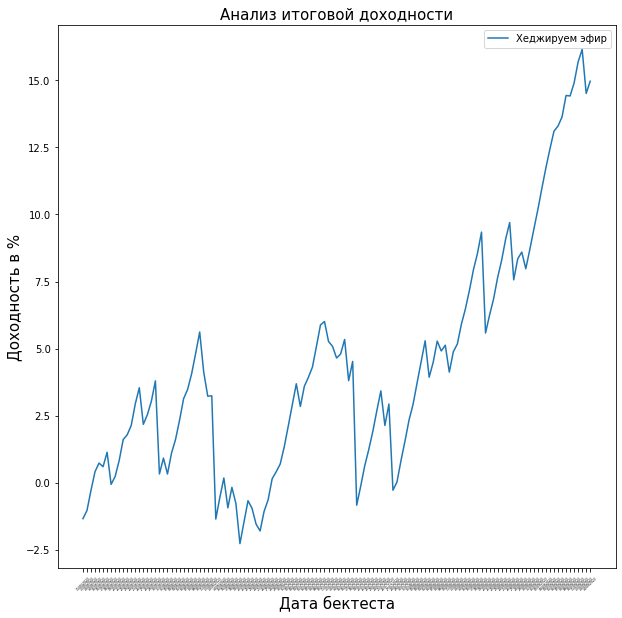

In [120]:
back_test_obj.plot_results()

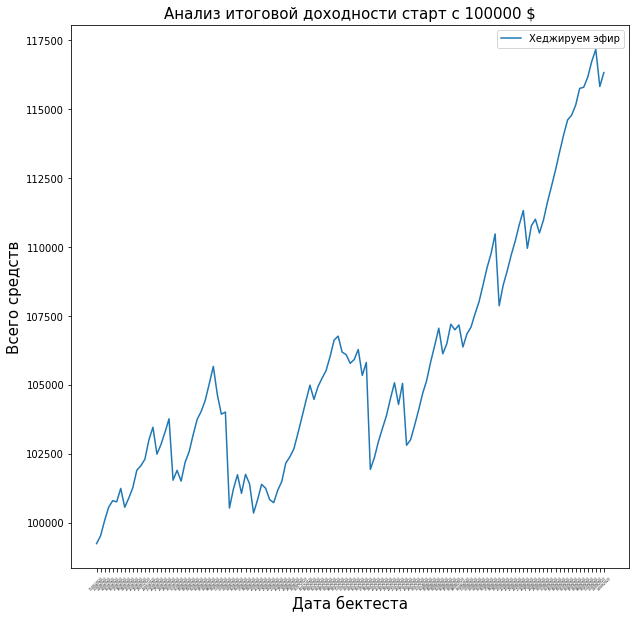

In [135]:
start_amount = 100000
gas_price = 10  # за одну операцию, внутри умножение на 2

back_test_obj.plot_results_alt(start_amount = start_amount, gas_price = gas_price, verbose=False)

### Рассмотрим как изменялся курс ETH/USDT

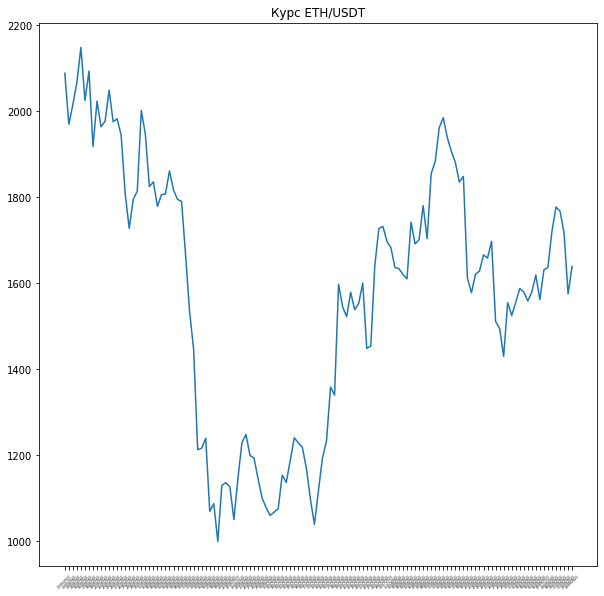

In [30]:
back_test_obj.plot_price()

### Дополнительно проверим как распределены изменения в стоимости (после 24 часов)¶


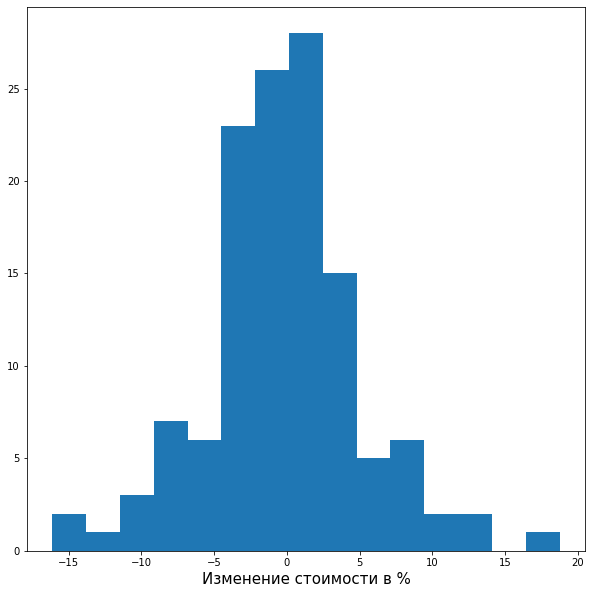

In [127]:
back_test_obj.change_price_distr()

In [ ]:
10000
50%50 

хедж 1000
нужно зехеджировать 4500

1200 эфир
20% - ликвидация???

1440.0?

220*5

In [128]:
1200*1.2

1440.0

# проверка логики работы

In [5]:
# Функция для построения кривой
def simulate(start_price, end, high_board, low_board, hedge, earnings):
    a1 = unforward_earnings(start_price, end, high_board, low_board)
    a2 = earnings
    a3 = -hedge*(end - start_price)/start_price*100
    return a1+a2+a3

### новая схема, проверка симметрии(еще раз проверим, что все симметрично, не смотря на уход части средств в хедж) Спойлер - все симметрично, просто доходность падает пропорционально тому, сколько средств ушло в хедж (они не работают)


In [61]:


def new_simulate(current_amount, start_price, end_price, high_board, low_board,  earnings):
    ratio_hedge = calc_ratio(start_price, high_board, low_board)
    eth_pool = ratio_hedge*current_amount/(1+ratio_hedge)
    usd_pool = current_amount - 2*eth_pool
    usd_hedge = eth_pool

    # Получим непрямые прибыли/убытки от пула в процентах
    e1 = unforward_earnings(start_price, end_price, high_board, low_board)
    e1 = e1/100*(eth_pool+usd_pool) # переведем в деньги: прибыль

    # получим прибыль/убыток от хеджа
    e2 = simple_hedge(start_price, end_price, ratio_hedge)
    # небольшой костыль, чтобы вернуться просто к процентам от хеджа
    e2 = e2/(100*ratio_hedge)
    e2 = usd_hedge*e2  # переведем в доллары

    # получим прибыль от стейкинга
    e3 = earnings
    e3 = e3/100 # уход от %
    e3 = (eth_pool+usd_pool)*e3# переведем в деньги
    # суммируем прибыли и изначальную сумму
    earn = e1 + e2 + e3 + current_amount
    return (earn-current_amount)/current_amount*100

In [140]:
current_amount = 10000
start_price = 1221
high_board = 1260
low_board = 1195
earnings = 0.7

In [141]:
end=1600
new_simulate(current_amount, start_price, end, high_board, low_board, earnings)

-10.603654791154804

In [142]:
end_prises = list(range(1000,1400))
list2 = list(map((lambda x: new_simulate(current_amount, start_price, x, high_board, low_board, earnings)), end_prises))
list3 = list(map((lambda x: (x-start_price)/start_price*100), end_prises))

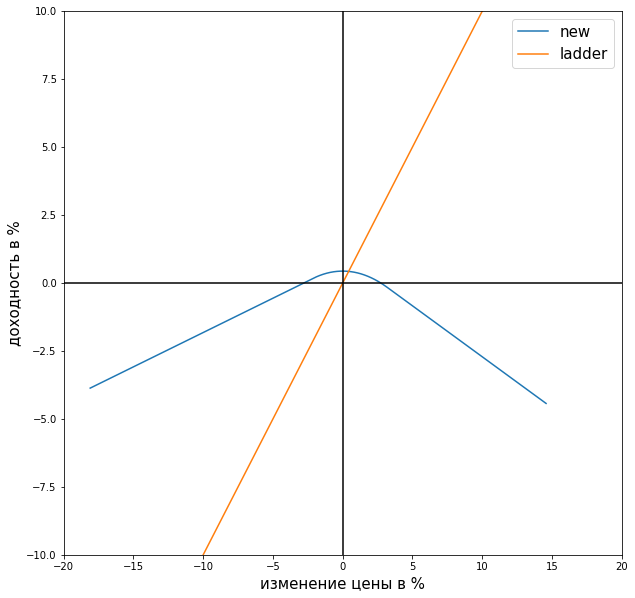

In [143]:
plt.figure(figsize=(10,10))
plt.plot(list3, list2, label='new')
plt.plot(list3, list3, label='ladder')
plt.plot([0, 0], [-20, 20], c='black')
plt.plot([-20, 20], [0, 0], c='black')
plt.xlabel('изменение цены в %', fontsize=15)
plt.ylabel('доходность в %', fontsize=15)
plt.ylim([-10, 10])
plt.xlim([-20, 20])
plt.legend(prop={'size':15})

# Прогнозы в реальном времени

###  Функции и зависимости 

In [144]:
from datetime import datetime, timedelta
def dataset_for_current_pred(symbol = 'ETHUSDT'):
  '''Функция возвращает последние доступные данные'''
  api_key = ""
  api_secret = ""
  client = Client(api_key, api_secret)
  current_date = datetime.now().strftime("%d-%m-%Y")
  yesterday = (datetime.now()+timedelta(days=-1)).strftime("%d/%m/%Y")
  tommorow = (datetime.now()+timedelta(days=+1)).strftime("%d/%m/%Y") 

  fromDate = str(datetime.strptime(yesterday, '%d/%m/%Y'))
  toDate = str(datetime.strptime(tommorow, '%d/%m/%Y'))
  symbol = symbol
  interval = Client.KLINE_INTERVAL_1MINUTE
  # посколько реализована подгрузка начиная со вчерашнего дня, разумно обрезать датасет 24 часами 24*60=1440
  df = GetHistoricalData(symbol, interval, fromDate, toDate)[-1440:] 
  return df

def bootstrap(mass, n_forcast, intervals_in_hour):
    '''Функция бутстрэпит изменения за прошедшие часы (это длина массива) n_forcast*intervals_in_hour раз, 
    процедура повторяется 10000 раз, в резульатате мы перемножеаем значения и выдаем прогноз в каждой точке таким образом (10000 симуляций)'''
    mass_res = np.zeros((10000, 2)) # 2 - нижняя и верхняя границы для каждой симуляции
    mass = np.array(mass) # переводим в numpy
    n = len(mass) # длина выборки для обучения
    size_forecast = n_forcast*intervals_in_hour
    # случайно берем числа до n, размера n_forcast*intervals_in_hour
    indexes = np.random.randint(n, size=size_forecast*10000)
    change = mass[[indexes]]
    change = change.reshape((10000, size_forecast))
    # теперь рассомтрим куммулятивное перемножение- предсказанное поведение
    cum_change = np.cumprod(change, axis=1)
    # минимальное и максимальные значения внутри временного интервалла
    min_ = np.min(cum_change, axis=1)
    max_ = np.max(cum_change, axis=1)
    sorted_res_min = np.sort(min_)
    sorted_res_max = np.sort(max_)
    #######################
    high, low = sorted_res_max[9500], sorted_res_min[500]
    return np.array([high, low])
def make_new_col(df):
    '''Потребуются относительные изменения'''
    print('Добавляю относительные изменения')
    mass = np.zeros(len(df))
    mass[0] = 1 # первую точку доопределяем 1
    values = df['open'].values.astype(float)
    for i in range(1, len(df)):
        mass[i] = values[i]/values[i-1]
        df['change'] = mass
    return df

def calc_ratio(start_price, high_board, low_board):
    return (high_board-start_price)/(high_board-low_board)

### Требуется ввести сумму средств

In [145]:
# требуется ввести сумму средств
current_amount = 10000

### Запускаем расчет

In [146]:

#Получаем данные
df_current = dataset_for_current_pred()

# Добавляем новую колонку
df_current = make_new_col(df_current)

# требуется для абсолютных значений запомнить текущую
current_value = df_current['open'].values.astype(float)[-1]
# Рассчитываем сам интервал
res_interval = bootstrap(df_current['change'].values, n_forcast=24, intervals_in_hour=60)*current_value

# рассчитываем ratio_hedge
start_price = current_value
high_board = res_interval[0]
low_board = res_interval[1]

ratio_hedge = calc_ratio(start_price, high_board, low_board)

eth_pool = ratio_hedge*current_amount/(1+ratio_hedge)
usd_pool = current_amount - 2*eth_pool
usd_hedge = eth_pool
print('Распределение средств в долларах')
print('Сумма эфира(в usdt) в пул', eth_pool)
print('Сумма usdt в пул', usd_pool)
print('Покупка фьючерса ',usd_hedge)



Добавляю относительные изменения


<ipython-input-144-91e568e30bdf>:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  change = mass[[indexes]]


Распределение средств в долларах
Сумма эфира(в usdt) в пул 3807.967270344617
Сумма usdt в пул 2384.0654593107656
Покупка фьючерса  3807.967270344617


In [147]:
res_interval

array([1281.69781612, 1184.46220239])

In [99]:
current_value

1222.59